# Bayesian Model Fitting Instance

一個 Bayesian model fitting的範例，幫助如何使用Bayesian model解決問題。

## Bayes rule

定義一個likelihood $P(D | M)$，其中$D$為來自於model $M$的實驗數據。

基於預期知識$C$，定義一個model $M$的prior $P(M | C)$，其中model $M$包含一些我們想要找的參數。

則由Bayes' theorem可以得知posterior：

$$P(M | D)\propto P(M | C)P(D | M)$$

## Linear models
假設有一個感測器，其量測到的信號被一個高斯雜訊影響，則可以將信號產生模型寫成: $y=a + noise$，其中$y$為量測到的data，$a$是模型的參數。

首先我們先產生人造的data：

In [1]:
%matplotlib inline
import scipy as sp
import matplotlib.pyplot as plt

a = 5                      # true mean of the optical signal
s = 4                      # true noise std 
n = 20                     # data points
y = a + s * sp.randn(n,1)  # Generate n data

根據generative model，隱含了likelihood可以被表示成$p(y|a) = \prod_{i=1}^{n} (2\pi\sigma^2)^{-1/2} e^{-\frac{(y_i-a)^2}{2\sigma^2}}$

In [2]:
va  = sp.linspace(-15,15,1000)
N   = va.shape[0]
lik = sp.exp(-.5 * sp.sum((sp.tile(y, [1,N])-sp.tile(va, [n,1]))**2, 0) / s**2)
lik = lik / sp.sum(lik) # normalize

在還沒量測之前，我們猜測量測到的信號會是中心為0且標準差為5的Gaussian distribution

In [3]:
a0  = 0
s0  = 5
pr  = sp.exp(-.5 * (va-a0)**2 / s0**2)
pr  = pr / sp.sum(pr)

根據Bayes theorem，可以推得模型的posterior： $p(a|y) = p(a) \times p(y|a)$

我們將上述的distribution都畫出：

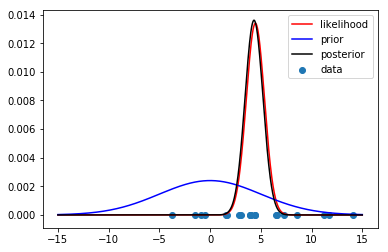

The value of variable a with maxium likelihood is 4.4595

The value of variable a with maxium posterior is 4.3393



In [4]:
po = lik * pr
po = po / sp.sum(po)
ML = va[sp.argmax(lik)]
MAP = va[sp.argmax(po)]
plt.figure(1)
hli = plt.plot(va, lik, 'r')
hpr = plt.plot(va, pr, 'b')
hpo = plt.plot(va, po, 'k')
plt.scatter(y, sp.zeros(y.shape))
plt.legend(['likelihood', 'prior', 'posterior', 'data'])
plt.show()
print('The value of variable a with maxium likelihood is {:.4f}\n'.format(ML))
print('The value of variable a with maxium posterior is {:.4f}\n'.format(MAP))

只藉由少量的data，可以發現機率最高的參數已經接近我們的真實信號產生模型參數，其中likelihood是只利用所量測到的data估計模型參數，而posterior是加入prior修正後的結果或是妥協，如果data愈多，則會傾向於相信data。

## Grid search for two variables
若我們不知道雜訊的標準差，則也需要將雜訊的標準差加入為需要尋找的模型參數。

舉例來說，一個信號$x$會在感測器上有$a$的增益，但是量測到的信號會被雜訊所影響，則模型可以寫成：$y=a \times x + noise$

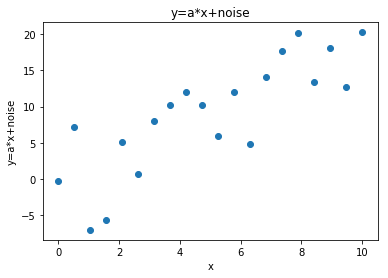

In [5]:
a   = 2 # true a
sig = 5 # true sigma
x   = sp.linspace(0, 10, n)
y = a * x + sig * sp.randn(x.shape[0])
y = y.reshape([len(x)])
# plot data
plt.figure(2)
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y=a*x+noise')
plt.title('y=a*x+noise')
plt.show()

Grid search就是取樣大量的參數來尋找最佳的參數組合，因此我們對$a$與$\sigma^2$取樣，希望計算posterior最高的參數組合

In [6]:
def normpdf(x, mu, sigma):
    u = (x-mu)/abs(sigma)
    y = (1 / (sp.sqrt(2*sp.pi) * abs(sigma)))* sp.exp(-u*u/2)
    return y

va = sp.linspace(0,5,100)       # values of a
vs = sp.linspace(0.01,50,100)  # values of s^2
posterior = sp.zeros([vs.shape[0],va.shape[0]])

for i in range(vs.shape[0]):
    for j in range(va.shape[0]):
        S  = va[j] * x    # prediction
        lik = vs[i]**(-n/2) * sp.exp((-0.5)*sp.sum((y-S)**2) / vs[i])   # likelihood
        pr = 1/vs[i] * normpdf(va[i], 0, 4)                             # prior
        posterior[i, j] = lik * pr                                      # posterior

posterior = posterior / sp.sum(posterior[:])

接著畫出posterior distribution:

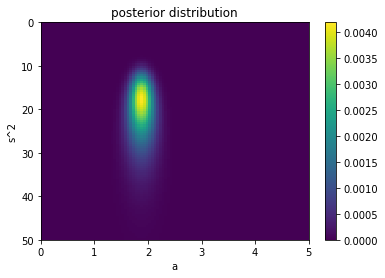

In [7]:
plt.figure(3)
plt.imshow(posterior, extent=[va[0],va[va.shape[0]-1],vs[vs.shape[0]-1],vs[0]], aspect='auto')
plt.xlabel('a')
plt.ylabel('s^2')
plt.title('posterior distribution')
plt.colorbar()
plt.show()

然後藉由對中一個參數做積分，我們可以畫出marginal probability，也就是兩個參數的機率分布

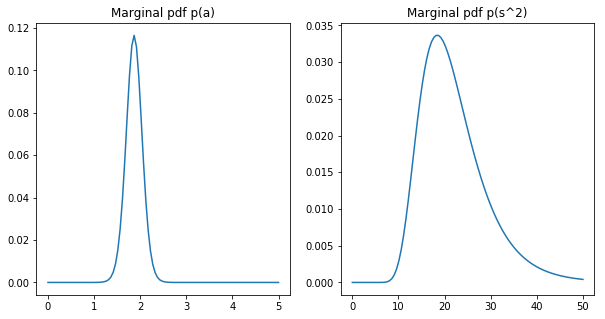

The value of variables with maxium posterior are 1.8687 and 17.6832



In [8]:
# plot marginals
plt.figure(4,figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Marginal pdf p(a)')
plt.plot(va, sp.sum(posterior,0)) # sum one dimension of grid
plt.subplot(1,2,2)
plt.title('Marginal pdf p(s^2)')
plt.plot(vs, sp.sum(posterior,1))
plt.show()
maxidx = sp.unravel_index(posterior.argmax(), posterior.shape)
print('The value of variables with maxium posterior are {:.4f} and {:.4f}\n'.format(va[maxidx[1]], vs[maxidx[0]]))

最後我們就能得到最佳的參數組合。

## Reference
[ONBI - Bayesian model fitting practical](https://users.fmrib.ox.ac.uk/~saad/ONBI/bayes_practical.html)